In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
from constants import NWABounds
import constants
import calculation_functions
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import spearmanr
import map_trend_functions
import matplotlib.gridspec as gridspec

Matplotlib is building the font cache; this may take a moment.


In [2]:
import sys
from importlib import reload
sys.path.append('')
import load_dataset as load
import phase_calc_functions as phase_calc
import map_trend_functions
import phase_plot_functions as phase_plot
import miscellaneous#apply_masks

In [126]:
import constants
constants.IMAGE_SAVE_DIR

'/g/data/w40/ab2313/images/mjo_and_rainfall_trend_images'

In [3]:
import matplotlib
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)

import matplotlib.pylab as pylab

params = {'axes.labelsize' : 16,
         'legend.fontsize': 'x-large',
          'axes.titlesize': 'xx-large',
         }

pylab.rcParams.update(params)

In [4]:
image_dir = '/g/data/w40/ab2313/images/mjo_and_rainfall_trend_images/'

# Data

In [5]:
# Loading awap
awap = load.load_awap()
awap_ws = phase_calc.wet_season_year(awap)

# Loading RMM
rmm = load.load_rmm()
rmm_ws = phase_calc.wet_season_year(rmm)

awap_ws, rmm_ws = calculation_functions.match_dataset_time(awap_ws, rmm_ws)

awap_ws = miscellaneous.apply_masks(awap_ws)

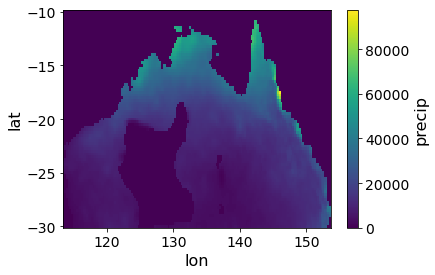

In [9]:
awap_ws.sum(dim = 'time').precip.plot()

# Phase Splitting and Wet Season Calibration

Splitting into different MJO phases (1-8) and then moving the data from Jan-March back one year. The moving of the data back one year means that all of the data for an individual wet season is now with in the one year. This makes resampling much easier.

In [10]:
# Splitting AWAP into the the different phases of the Wheeler and Hendon MJO
awap_split_ws = phase_calc.split_into_1to8(awap_ws, rmm_ws)

In [12]:
rmm_count = phase_calc.count_in_rmm_phase(rmm_ws)
rmm_count = calculation_functions.convert_time_to_year(rmm_count)
rmm_count_sub = phase_calc.resample_phase_to_subphase(rmm_count)
rmm_count_sub

<xarray.Dataset>
Dimensions:  (phase: 4, year: 46)
Coordinates:
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2016 2017 2018 2019 2020
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
Data variables:
    number   (phase, year) int64 21 28 25 18 23 28 11 ... 43 29 18 56 15 23 46

# Bootstrap Calculation

In [37]:
def trend_line(y, use = [0][0]):
    '''
    Parameters
    ----------
    x: the y values of our trend
    use: 
    [0][0] will just return the gradient
    [0,1] will return the gradient and y-intercept.
    Previosly: _grid_trend
    '''
#     if ~isinstance(y, np.ndarray) or ~isinstance(y, list):
#         return np.nan

    if all(~np.isfinite(y)):
        return np.nan


    # Getting the gradient of a linear interpolation
    x = np.arange(len(y))
    idx = np.isfinite(y) #checking where the nans.
    x = x[idx]
    y = y[idx]

    if len(x) < 3:
        return np.nan

    poly = np.polyfit(x,y,1)

    return poly[use].round(2)

In [14]:
def nancount_nonzero(array, axis):
    '''
    Counts all the non-zero and non-nan values in an array. Like the .count function for 
    xarray. Like count_nonzero for numpy but replaces nans with 0 first.
    '''
    return np.count_nonzero(np.where(np.isfinite(np.array(array)), array, 0), axis=axis)

In [15]:
enhanced_phase_times = (rmm_ws
                        .where(rmm.amplitude > 1, drop=True)
                        .where(rmm.phase.isin([4,5,6]), drop=True)
                        .time.values
                       )
enhanced_phase_times

array(['1975-01-08T00:00:00.000000000', '1975-01-09T00:00:00.000000000',
       '1975-01-10T00:00:00.000000000', ...,
       '2020-12-19T00:00:00.000000000', '2020-12-20T00:00:00.000000000',
       '2020-12-21T00:00:00.000000000'], dtype='datetime64[ns]')

In [16]:
awap_ws_array = awap_ws.precip.values
awap_ws_array.shape

(5578, 80, 161)

In [17]:
awap_time = pd.to_datetime(awap_ws.time.values)
awap_time

DatetimeIndex(['1975-01-01', '1975-01-02', '1975-01-03', '1975-01-04',
               '1975-01-05', '1975-01-06', '1975-01-07', '1975-01-08',
               '1975-01-09', '1975-01-10',
               ...
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30'],
              dtype='datetime64[ns]', length=5578, freq=None)

In [18]:
np.unique(awap_time.year)

array([1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020])

In [19]:
total_number_time_points = len(awap_ws.time.values)
total_number_time_points

5578

In [20]:
number_bootstrapping = 1000

In [39]:
def generate_bootstrapped_data(awap_ws_array, awap_time, func1d, number_bootstrapping=10):
    '''
    awap_ws_array: numpy.ndarray)
        Array of data converted from xarray to numpy array. Time has to be on axis 0.
    awap_time: numpy.ndarray
        Array of all the time values
    func1d: func1d
        Function that is applied for the trend. In this instnace should be either of np.nansum
        or nancount_nonzero.
    number_bootstrapping: int
        The number of itterations the bootstrapping should go through
    
    '''
    # Creating an empty array to store the output of each butstrap
    boostrap_itterations = np.empty(number_bootstrapping, dtype=np.ndarray)
    
    unique_years = np.unique(awap_time.year)
    total_number_time_points = len(awap_time)

    for num_bootstrap in range(number_bootstrapping):
        print(f'{num_bootstrap}, ', end='')
        # This is a list of empty lists. The data for each monsoon will be stored 
        # in one of the contained empty lists. They will be stored in teh list based upon 
        # which monsoon. E.g. 2020 will be in the last list.
        random_monsoon_list = [[] for i in range(len(unique_years))]

        # Create array of random data. 
        for random_number in np.random.randint(0,total_number_time_points, total_number_time_points):
            corrsepoding_time = awap_time[random_number]
            if corrsepoding_time in enhanced_phase_times:
                single_time_array = awap_ws_array[random_number]
                corrsepoding_time = awap_time[random_number]
                time_arg = int(np.argwhere(corrsepoding_time.year == unique_years))
                random_monsoon_list[time_arg].append(single_time_array)

        # Sum or count the data
        monsoon_list = []
        for single_bootstrap in random_monsoon_list:
            monsoon_yearly_stat = func1d(np.array(single_bootstrap), axis=0)
            monsoon_list.append(monsoon_yearly_stat)
   
        # For some reason, for certain monsoon lists, a single array is not passed in,
        # but rather and array of arrays. Happens very infrequently, and is hard to 
        # debug, but better to ignore.
        try:
            # Get the trend along the axis
            grad_trend = np.apply_along_axis(trend_line, 0, monsoon_list)
        except TypeError as e:
            print('Array error occured. Breaking loop')
            break
        

        # Get the sign of the trend
        sign_grad_trend = np.where(np.sign(grad_trend) > 0, 1, 0)

        # Store the sign of the trend.
        boostrap_itterations[num_bootstrap] = sign_grad_trend
        
    number_positive_trends = np.sum(boostrap_itterations)

    percent_trends_positive = number_positive_trends * 100 /number_bootstrapping 
        
    return percent_trends_positive

In [22]:
%%time
percent_trends_positive_sum  = generate_bootstrapped_data(awap_ws_array, awap_time, np.nansum,
                                                       number_bootstrapping=1000)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

In [40]:
%%time
percent_trends_positive_count = generate_bootstrapped_data(awap_ws_array, awap_time, nancount_nonzero,
                                                       number_bootstrapping=1000)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

In [45]:
import matplotlib as mpl

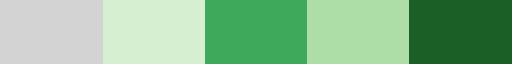

In [47]:
color_array = ['lightgrey', '#D6EFD1', '#3EA95B', '#ADDEA7', '#1B5F27']#['#FFD1B3', '#accbff', '#4188ff', '#FE994A']
bootstrap_cmap = mpl.colors.ListedColormap(color_array)
bootstrap_cmap

In [49]:
levels = (0, 90, 95, 99, 100)

norm = mpl.colors.BoundaryNorm(levels, bootstrap_cmap.N)

<xarray.DataArray 'precip' (lat: 80, lon: 161)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lat      (lat) float64 -30.0 -29.75 -29.5 -29.25 ... -10.5 -10.25 -10.0
  * lon      (lon) float64 113.5 113.8 114.0 114.2 ... 152.8 153.0 153.2 153.5

In [134]:
boostrap_sum_ds = xr.zeros_like(awap_ws.isel(time=0).drop('time')).rename({'precip': 'percent'})
boostrap_sum_ds += percent_trends_positive_sum

boostrap_count_ds = xr.zeros_like(awap_ws.isel(time=0).drop('time')).rename({'precip': 'percent'})
boostrap_count_ds += percent_trends_positive_count

boostrap_sum_ds

<xarray.Dataset>
Dimensions:  (lat: 80, lon: 161)
Coordinates:
  * lat      (lat) float64 -30.0 -29.75 -29.5 -29.25 ... -10.5 -10.25 -10.0
  * lon      (lon) float64 113.5 113.8 114.0 114.2 ... 152.8 153.0 153.2 153.5
Data variables:
    percent  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    Information:  Only contains the wet season [10,11,12,1,2,3],rainfall >= 1...
    History:      AGCD Regrid on the 11th of June 2021 from /g/data/rr5 by ab...

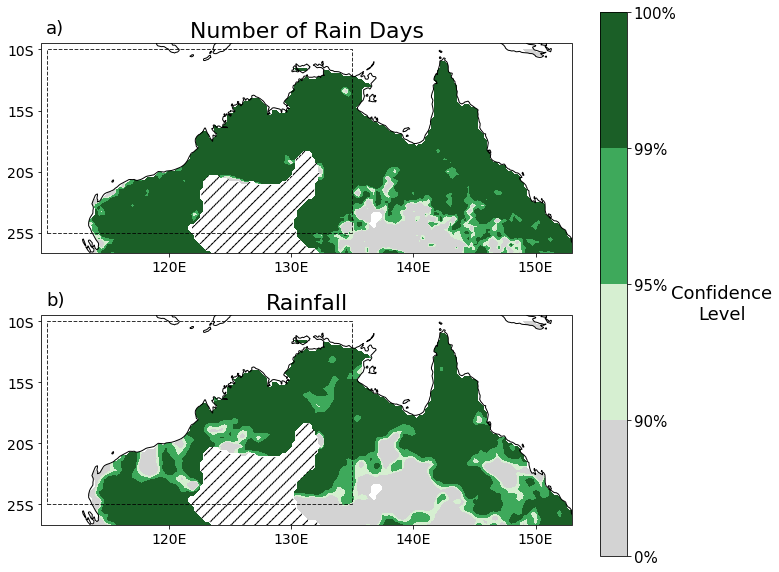

In [138]:
reload(pf)

fig, gs = pf.fig_formatter(height_ratios = [1,1], width_ratios = [1, 0.05], hspace = 0.0, wspace = 0.1)

ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
c = ax1.contourf(boostrap_count_ds.lon, boostrap_count_ds.lat, 
                miscellaneous.apply_masks(boostrap_count_ds).percent.values, 
                cmap=bootstrap_cmap, levels=levels, norm=norm, projection=ccrs.PlateCarree())

map_trend_functions.format_lat_lon(ax1)
ax1.set_title('Number of Rain Days', size=22)
ax1.annotate('a)', xy = (0.01,1.05), xycoords = 'axes fraction', size = 18)

ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())

c = ax2.contourf(boostrap_sum_ds.lon, boostrap_sum_ds.lat, 
                miscellaneous.apply_masks(boostrap_sum_ds).percent.values, 
                cmap=bootstrap_cmap, levels=levels, norm=norm, projection=ccrs.PlateCarree())

map_trend_functions.format_lat_lon(ax2)
ax2.set_title('Rainfall', size=22)
ax2.annotate('b)', xy = (0.01,1.05), xycoords = 'axes fraction', size = 18)


cax = plt.subplot(gs[:,1])
ticks = [str(l) + '%' for l in levels]
pf.create_colorbar(c, cax, levels,  ticks=ticks,
                   cbar_title =  "Confidence\nLevel",
                   xtickSize= 15, cbar_titleSize = 18, orientation = 'vertical', rotation = 0, 
                  labelpad=45)

fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR, '05_boostrapping_awap_count_sum.png'),
            bbox_inches='tight', dpi=500)

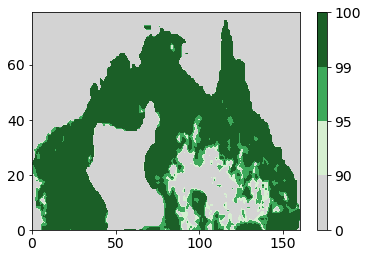

In [55]:
c = plt.contourf(percent_trends_positive_count, cmap=bootstrap_cmap, levels=levels,
                norm=norm)

plt.colorbar(c)

# Bad Version
Saves all the data then calcualtes the trend

In [16]:
def generate_array_of_random_mosoon_data(awap_ws_array: np.ndarray, awap_time: np.ndarray, 
                                         unique_years, enhanced_phase_times,
                                         number_bootstrapping: int=100) -> np.ndarray:
    
    '''
    Generates an array of length 'number_bootstrapping'. Each elemnt of the array is of length
    'awap_time' and contains random data selected.
    
    In summary this is creating random monsoon, and the number of these created is 'number_bootstrapping'
    
    awap_ws_array: numpy.ndarray)
        Array of data converted from xarray to numpy array. Time has to be on axis 0.
    awap_time: numpy.ndarray
        Array of all the time values
    func1d: func1d
        Function that is applied for the trend. In this instnace should be either of np.nansum
        or 
    number_bootstrapping: int
        The number of itterations the bootstrapping should go through
    
    '''
    # Creating an empty array to store the output of each butstrap
    boostrap_itterations = np.empty(number_bootstrapping, dtype=np.ndarray)

    for num_bootstrap in range(number_bootstrapping):
        print(f'{num_bootstrap}, ', end='')
        # This is a list of empty lists. The data for each monsoon will be stored 
        # in one of the contained empty lists. They will be stored in teh list based upon 
        # which monsoon. E.g. 2020 will be in the last list.
        random_monsoon_list = [[] for i in range(len(unique_years))]

        # Create array of random data. 
        for random_number in np.random.randint(0,total_number_time_points, total_number_time_points):
            corrsepoding_time = awap_time[random_number]
            if corrsepoding_time in enhanced_phase_times:
                single_time_array = awap_ws_array[random_number]
                corrsepoding_time = awap_time[random_number]
                time_arg = int(np.argwhere(corrsepoding_time.year == unique_years))
                random_monsoon_list[time_arg].append(single_time_array)

        boostrap_itterations[num_bootstrap] = random_monsoon_list
    return boostrap_itterations

In [46]:
def calculate_monsoon_stats(boostrap_itterations: np.ndarray, func1d = np.nansum):
    '''
    Loop through all the randomly geneated monsoon and get the sum/count of the rainfall events
    in each year. This is a nested loop as there is both the number of boostrap itterations and the 
    individual years
    '''
    monsoon_itterations = np.empty(len(boostrap_itterations), dtype=np.ndarray) #[]
    for num, monsoon_list in enumerate(boostrap_itterations):
        print(f'{num}, ', end='')
        # Sum or count the data
        monsoon_stat_list = np.empty(len(monsoon_list), dtype=np.ndarray) #[]
        for year, single_monsoon in enumerate(monsoon_list):
            # Time axis must be zero
            # Sum all the rainfall for a single  on monsoon
            monsoon_single_time = func1d(np.array(single_monsoon), axis=0)
            monsoon_stat_list[year] = monsoon_single_time#.append(monsoon_single_time)
        monsoon_itterations[num] = monsoon_stat_list
        # monsoon_itterations.append(np.array(monsoon_stat_list))
            
    return monsoon_itterations

In [32]:
def calculate_gradient_of_itterations(monsoon_stat_list: np.ndarray):
    '''Calculate the trend line along the 0th axis.
    Then calculate 
    
    '''
    gradient_list = []
    for num, boostrap_itteration in enumerate(monsoon_stat_list):
        print(f'{num}, ', end='')
        # Get the trend along the time axis
        boostrap_itteration = np.array(boostrap_itteration)
        grad_trend = np.apply_along_axis(trend_line, 0, boostrap_itteration)

        # Get the sign of the trend
        # sign_grad_trend = np.where(np.sign(grad_trend) > 0, 1, 0)
        
        gradient_list.append(grad_trend)
        
    return np.array(gradient_list)

In [19]:
def get_percent_of_positive_gradients(gradient_list, number_bootstrapping):
    '''The percent of gradients that are positive'''

    # 1 if greater than 0, 0 if not.
    positive_gradient_list = np.where(np.sign(gradient_list) > 0, 1, 0)

    total_positive_gradients = np.sum(positive_gradient_list, axis=0)

    percent_positive_gradients = total_positive_gradients * 100 /number_bootstrapping 
    
    return percent_positive_gradients

In [20]:
def nancount_nonzero(array, axis):
    '''
    Counts all the non-zero and non-nan values in an array. Like the .count function for 
    xarray. Like count_nonzero for numpy but replaces nans with 0 first.
    '''
    return np.count_nonzero(np.where(np.isfinite(np.array(array)), array, 0), axis=axis)

In [21]:
enhanced_phase_times = (rmm_ws
                        .where(rmm.amplitude > 1, drop=True)
                        .where(rmm.phase.isin([4,5,6]), drop=True)
                        .time.values
                       )
enhanced_phase_times

array(['1975-01-08T00:00:00.000000000', '1975-01-09T00:00:00.000000000',
       '1975-01-10T00:00:00.000000000', ...,
       '2020-12-19T00:00:00.000000000', '2020-12-20T00:00:00.000000000',
       '2020-12-21T00:00:00.000000000'], dtype='datetime64[ns]')

In [22]:
awap_ws_array = awap_ws.precip.values
awap_ws_array.shape

(5578, 80, 161)

In [23]:
awap_time = pd.to_datetime(awap_ws.time.values)
awap_time

DatetimeIndex(['1975-01-01', '1975-01-02', '1975-01-03', '1975-01-04',
               '1975-01-05', '1975-01-06', '1975-01-07', '1975-01-08',
               '1975-01-09', '1975-01-10',
               ...
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30'],
              dtype='datetime64[ns]', length=5578, freq=None)

In [24]:
unique_years = np.unique(awap_ws.time.dt.year.values)
unique_years

array([1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020])

In [25]:
total_number_time_points = len(awap_ws.time.values)
total_number_time_points

5578

In [26]:
number_bootstrapping = 1000

In [27]:
%%time
# Generate random boostrapped data
boostrap_itterations_2 = generate_array_of_random_mosoon_data(awap_ws_array, awap_time, 
                                                unique_years, enhanced_phase_times,
                                         number_bootstrapping=number_bootstrapping)


0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

In [75]:
%%time
monsoon_itteration_count = calculate_monsoon_stats(boostrap_itterations_2, func1d=nancount_nonzero)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

In [ ]:
%%time
monsoon_itteration_sum = calculate_monsoon_stats(boostrap_itterations_2, func1d=np.nansum)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

In [ ]:
gradients_sum = calculate_gradient_of_itterations(monsoon_itteration_sum)

percent_positive_gradient_sum = get_percent_of_positive_gradients(gradients_sum, number_bootstrapping)
percent_positive_gradient_sum.shape

In [ ]:
gradients_count = calculate_gradient_of_itterations(monsoon_itteration_count)

percent_positive_gradient_count = get_percent_of_positive_gradients(gradients_count, number_bootstrapping)
percent_positive_gradient_count.shape

In [ ]:
vmax = np.max(percent_positive_gradient_count)

c = plt.pcolormesh(percent_positive_gradient_count, cmap='Blues', vmax=vmax, vmin=0)

plt.colorbar(c)

In [ ]:
vmax = np.max(percent_positive_gradient_sum)

c = plt.pcolormesh(percent_positive_gradient_sum, cmap='Blues', vmax=vmax, vmin=0)

plt.colorbar(c)

# Old

In [263]:
def generate_bootstrapped_data(awap_ws_array, awap_time, func1d, number_bootstrapping=10):
    '''
    awap_ws_array: numpy.ndarray)
        Array of data converted from xarray to numpy array. Time has to be on axis 0.
    awap_time: numpy.ndarray
        Array of all the time values
    func1d: func1d
        Function that is applied for the trend. In this instnace should be either of np.nansum
        or 
    number_bootstrapping: int
        The number of itterations the bootstrapping should go through
    
    '''
    # Creating an empty array to store the output of each butstrap
    boostrap_itterations = np.empty(number_bootstrapping, dtype=np.ndarray)

    for num_bootstrap in range(number_bootstrapping):
        print(f'{num_bootstrap}, ', end='')
        # This is a list of empty lists. The data for each monsoon will be stored 
        # in one of the contained empty lists. They will be stored in teh list based upon 
        # which monsoon. E.g. 2020 will be in the last list.
        empty_len_year_list = [[] for i in range(len(unique_years))]

        # Create array of random data. 
        for random_number in np.random.randint(0,total_number_time_points, total_number_time_points):
            corrsepoding_time = awap_time[random_number]
            if corrsepoding_time in enhanced_phase_times:
                single_time_array = awap_ws_array[random_number]
                corrsepoding_time = awap_time[random_number]
                time_arg = int(np.argwhere(corrsepoding_time.year == unique_years))
                empty_len_year_list[time_arg].append(single_time_array)

        # Sum or count the data
        monsoon_total_list = []
        for single_time_array in empty_len_year_list:
            monsoon_single_time = np.nansum(np.array(single_time_array), axis=0)
            monsoon_total_list.append(monsoon_single_time)
    

        # Get the trend along the axis
        grad_trend = np.apply_along_axis(trend_line, 0, monsoon_total_list)

        # Get the sign of the trend
        sign_grad_trend = np.where(np.sign(grad_trend) > 0, 1, 0)

        # Store the sign of the trend.
        boostrap_itterations[num_bootstrap] = sign_grad_trend
        
    return boostrap_itterations

In [266]:
%%time
boostrap_itterations_sum  = generate_bootstrapped_data(
    awap_ws_array, awap_time, np.nansum, number_bootstrapping=1000)

0, CPU times: user 3.21 s, sys: 16.5 ms, total: 3.23 s
Wall time: 3.27 s
